In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.imputation.mice import MICE, MICEData
# import fancyimpute
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
# from imblearn.over_sampling import SMOTE
import time
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("C:/Users/mvand/Documents/UZH/FS20/Intro to Machine Learning/Group Project/Clean Mapping.csv", sep=';',
                parse_dates=['adate', 'qdate', 'public_date', 'datadate'])

In [3]:
df.shape

(29409, 88)

In [4]:
df = df[df['splticrm'] != 'D']
df = df[df['splticrm'] != 'CCC']

In [5]:
#drop all rows where splticrm has NA values:
df = df[df['splticrm'].notna()]

In [6]:
Y = pd.factorize(df["splticrm"])[0]
print(np.bincount(Y))
print(pd.factorize(df["splticrm"])[1])
Y = pd.DataFrame(Y, columns=["Rating as Factor"])
print(Y)

[3656 1943  990  296 5455 3209  489 3882 4682  199   50  143  382 1069
 1648 1096  220]
Index(['A', 'A+', 'AA-', 'AAA', 'BBB', 'BBB-', 'AA', 'A-', 'BBB+', 'AA+',
       'CCC+', 'B-', 'B+', 'BB-', 'BB+', 'BB', 'B'],
      dtype='object')
       Rating as Factor
0                     0
1                     0
2                     0
3                     0
4                     0
...                 ...
29404                 8
29405                 8
29406                 8
29407                 8
29408                 8

[29409 rows x 1 columns]


In [7]:
X = df.loc[:, df.columns != "splticrm"]
X = X.drop(["permno", "CUSIP", "NCUSIP", "adate", "qdate", "public_date", "TICKER"], axis=1)
X = X.drop(["COMNAM", "PERMCO", "NWPERM", "gvkey", "datadate", "tic", "cusip", "conm", "PRC"], axis=1)
X.head()

,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,DIVYIELD,PEG_1yrforward,PEG_ltgforward
0,26.386,0.252,10.110,19.217,19.378,20.052,20.052,4.976,13.353,0.129,...,1.894,0.120,0.003,0.0,0.058,4.145,1.045,0.00867,2.221,1.554
1,28.226,0.252,10.110,20.542,20.714,21.435,21.435,5.323,14.285,0.129,...,1.894,0.120,0.003,0.0,0.058,4.434,1.117,0.00811,2.058,1.520
2,29.464,0.252,10.110,21.425,21.605,22.357,22.357,5.556,14.911,0.129,...,1.894,0.120,0.003,0.0,0.058,4.628,1.165,0.00778,2.146,1.586
3,28.783,0.233,10.983,21.378,21.556,23.096,23.096,5.381,15.909,0.177,...,1.891,0.121,0.003,0.0,0.049,4.515,1.545,0.00773,1.848,1.642
4,25.096,0.233,10.983,18.653,18.808,20.152,20.152,4.692,13.871,0.177,...,1.891,0.121,0.003,0.0,0.049,3.937,1.348,0.00886,1.612,1.432


In [8]:
NAs = X.isnull().sum() > 10000
Zeros =  (X == 0).sum() > 10000
delNAs = X.columns[NAs] #drops PEG_trailing
delZeros= X.columns[Zeros] #drops rd_sale, adv_sale, staff_sale
X = X.drop(delNAs, axis=1)
X = X.drop(delZeros, axis=1)

In [9]:
#now do the train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=Y)

In [10]:
X_train.head(1)


,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,accrual,ptb,DIVYIELD,PEG_1yrforward,PEG_ltgforward
6595,36.03,0.235,12.83,11.986,12.131,13.943,6.876,1.884,13.644,0.334,...,4.891,4.585,1.665,2.794,4.008,0.062,4.444,0.0133,0.978,1.281


In [11]:
X_train.isna().sum()

CAPEI               47
bm                 529
evm                 76
pe_op_basic        274
pe_op_dil          278
                  ... 
accrual             28
ptb                529
DIVYIELD          4003
PEG_1yrforward     799
PEG_ltgforward    1286
Length: 67, dtype: int64

In [12]:
## define function for IterativeImputer

from sklearn.experimental import enable_iterative_imputer 
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

#def iterative_imputer(df):
   # """ Impute the missing values (NaN) with the IterativeImputer
    
    #Args:
     #   df: feature matrix with NaN values to be imputed
    #"""
    #Define all column with numeric values (the features)
    #num_cols = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 
     #       'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq',
      #      'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap',
       #     'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act',
        ##    'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct',
          #  'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov',
           ## 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
            #'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'accrual', 'ptb',
            #'DIVYIELD', 'PEG_1yrforward', 'PEG_ltgforward']

    # Copy df to df_imputed
    #df_imputed = df[num_cols].copy(deep=True)

    # Initialize IterativeImputer
    #mice_imputer = IterativeImputer()

    # Impute using fit_tranform on df
    #df_imputed.iloc[:, :] = mice_imputer.fit_transform(df[num_cols])
    

In [13]:
# apply IterativeImputer
### here I still have to implement the correct function

num_cols = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 
            'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq',
            'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap',
            'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act',
            'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct',
            'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov',
            'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
            'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'accrual', 'ptb',
            'DIVYIELD', 'PEG_1yrforward', 'PEG_ltgforward']

# Copy df to df_mice_imputed
X_train_imputed = X_train[num_cols].copy(deep=True)

# Initialize IterativeImputer
mice_imputer = IterativeImputer(random_state=0)

# Impute using fit_tranform on diabetes
X_train_imputed.iloc[:, :] = mice_imputer.fit_transform(X_train[num_cols])

# Copy df to df_mice_imputed
X_test_imputed = X_test[num_cols].copy(deep=True)

# Impute using tranformation of training set on test set
X_test_imputed.iloc[:, :] = mice_imputer.transform(X_test[num_cols])


C:\Users\mvand\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [14]:
# impute the missing values with IterativeImputer

#X_train_imputed = iterative_imputer(dataframe=X_train)
#X_test_imputed = iterative_imputer(dataframe=X_test)


In [15]:
from sklearn.ensemble import RandomForestClassifier

def feature_selection(x, y, n):
    """ Find out, which the most important features are.
    
    Args:
        x: feature input without NaN values
        y: classification input
        n: number of most important features, that need to be calculated
    """
    
    feat_labels = x.columns[:]
    
    # Create Random Forest object, fit data and
    # extract feature importance attributes
    forest = RandomForestClassifier(random_state=1, class_weight = 'balanced')
    forest.fit(x, y)
    importances = forest.feature_importances_
    
    # Get cumsum of the n most important features
    feat_imp = np.sort(importances)[::-1]
    sum_feat_imp = np.cumsum(feat_imp)[:n]
    
    # Sort output (by relative importance) and 
    # print top n features
    indices = np.argsort(importances)[::-1]
    for i in range(n):
        print('{0:2d}) {1:7s} {2:6.4f}'.format(i + 1, 
                                           feat_labels[indices[i]],
                                           importances[indices[i]]))
    
    # Plot Feature Importance (both cumul., individual)
    plt.figure(figsize=(12, 8))
    plt.bar(range(n), importances[indices[:n]], align='center')
    plt.xticks(range(n), feat_labels[indices[:n]], rotation=90)
    plt.xlim([-1, n])
    plt.xlabel('Feature')
    plt.ylabel('Rel. Feature Importance')
    plt.step(range(n), sum_feat_imp, where='mid', 
         label='Cumulative importance')
    plt.tight_layout();
    
    # Create a list with the important features for ML algorhithms
    feature_list = [None] * n
    for i in range(n):
        feature_list[i] = feat_labels[indices[i]]
    
    # return the list of important features
    return feature_list

 1) intcov_ratio 0.0285
 2) gpm     0.0220
 3) int_totdebt 0.0218
 4) intcov  0.0217
 5) debt_assets 0.0211
 6) cfm     0.0200
 7) rect_turn 0.0196
 8) inv_turn 0.0194
 9) dpr     0.0193
10) debt_ebitda 0.0192
11) DIVYIELD 0.0192
12) lt_debt 0.0192
13) cash_conversion 0.0192
14) CAPEI   0.0188
15) invt_act 0.0184
16) lt_ppent 0.0183
17) pretret_noa 0.0182
18) debt_invcap 0.0175
19) rect_act 0.0173
20) ptpm    0.0170
21) roce    0.0168
22) debt_capital 0.0168
23) equity_invcap 0.0167
24) GProf   0.0166
25) debt_at 0.0164
26) sale_equity 0.0163
27) sale_invcap 0.0159
28) capital_ratio 0.0158
29) ps      0.0158
30) totdebt_invcap 0.0158
31) at_turn 0.0158
32) dltt_be 0.0158
33) cash_debt 0.0157
34) int_debt 0.0157
35) opmbd   0.0156
36) pay_turn 0.0151
37) pretret_earnat 0.0149
38) de_ratio 0.0149
39) npm     0.0148
40) cash_lt 0.0145


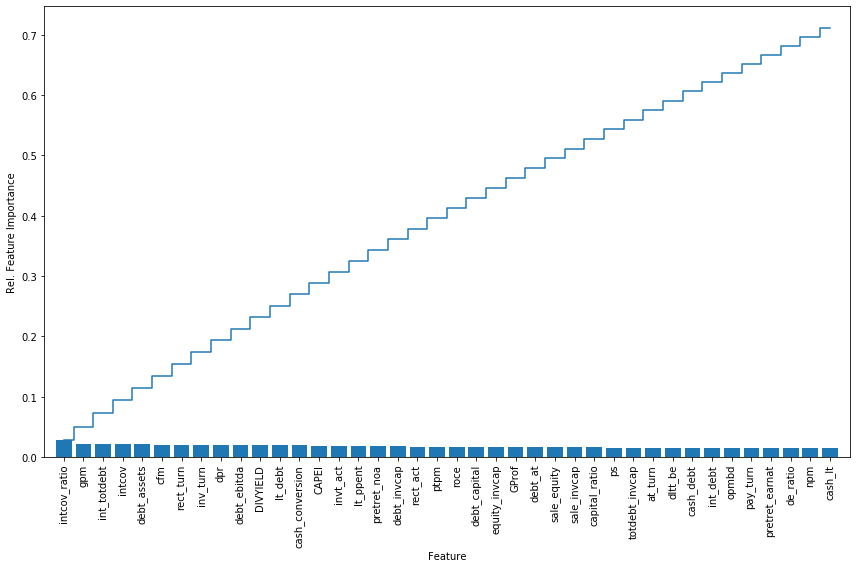

In [16]:
important_features = feature_selection(x = X_train_imputed, y = y_train.values.ravel(), n = 40)

In [17]:

#Subset important features matrix for ML algorithms
X_train_imputed = X_train_imputed.loc[:,important_features]
X_test_imputed = X_test_imputed.loc[:, important_features]

In [18]:
X_train_imputed.to_csv('X_train.csv')
X_test_imputed.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')